# 1. Build your own convolutional neural network using pytorch

In [1]:
import os
import torch
import timm
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)


In [2]:
root_path = "D:/Neural_Networks/Project_1/Dog_X_ray/Dog_X_ray"
train_dir = os.path.join(root_path, "Dog_heart", "Dog_heart", "Train")
valid_dir = os.path.join(root_path, "Dog_heart", "Dog_heart", "Valid")
test_dir = os.path.join(root_path, "Test", "Test")


In [3]:
image_size = 224
batch_size = 32
mean_vals = [0.485, 0.456, 0.406]
std_vals = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals)
])

eval_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean_vals, std_vals)
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
valid_dataset = datasets.ImageFolder(valid_dir, transform=eval_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

class_names = train_dataset.classes
num_classes = len(class_names)


In [4]:
class DogTestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if f.endswith('.png')]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, os.path.basename(path)

test_dataset = DogTestDataset(test_dir, transform=eval_transforms)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [5]:
# Use timm to load a pretrained EfficientNetB0 and fine-tune it
class EfficientNetDogHeart(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetDogHeart, self).__init__()
        self.base = timm.create_model('efficientnet_b0', pretrained=True)
        self.base.classifier = nn.Sequential(
            nn.Linear(self.base.classifier.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.base(x)

model = EfficientNetDogHeart(num_classes=num_classes).to(device)


C:\Users\Ashish Bhandari\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ashish Bhandari\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


# 2. Train your model using dog heart dataset

In [6]:
def train_model(model, train_loader, valid_loader, num_epochs=40):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    best_accuracy = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct, total_train = 0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_acc = train_correct / total_train
        avg_train_loss = train_loss / total_train

        # Validation
        model.eval()
        val_loss, val_correct, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = loss_fn(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_acc = val_correct / total_val
        avg_val_loss = val_loss / total_val
        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_model_state = model.state_dict()

    print(f"\nBest Validation Accuracy: {best_accuracy:.4f}")
    return best_model_state


In [7]:
# Train and load the best model
best_weights = train_model(model, train_loader, valid_loader, num_epochs=40)
model.load_state_dict(best_weights)


Epoch 1/40 | Train Loss: 0.8603 | Train Acc: 0.5264 | Val Loss: 0.9082 | Val Acc: 0.4850
Epoch 2/40 | Train Loss: 0.7357 | Train Acc: 0.6050 | Val Loss: 0.7686 | Val Acc: 0.6450
Epoch 3/40 | Train Loss: 0.6986 | Train Acc: 0.6543 | Val Loss: 0.6705 | Val Acc: 0.6950
Epoch 4/40 | Train Loss: 0.6440 | Train Acc: 0.6836 | Val Loss: 0.6968 | Val Acc: 0.6100
Epoch 5/40 | Train Loss: 0.6081 | Train Acc: 0.7086 | Val Loss: 0.6337 | Val Acc: 0.6900
Epoch 6/40 | Train Loss: 0.5789 | Train Acc: 0.7271 | Val Loss: 0.6411 | Val Acc: 0.6950
Epoch 7/40 | Train Loss: 0.5500 | Train Acc: 0.7400 | Val Loss: 0.7521 | Val Acc: 0.6500
Epoch 8/40 | Train Loss: 0.5691 | Train Acc: 0.7221 | Val Loss: 0.6731 | Val Acc: 0.6550
Epoch 9/40 | Train Loss: 0.5472 | Train Acc: 0.7371 | Val Loss: 0.7799 | Val Acc: 0.6300
Epoch 10/40 | Train Loss: 0.5360 | Train Acc: 0.7314 | Val Loss: 0.8481 | Val Acc: 0.6600
Epoch 11/40 | Train Loss: 0.4930 | Train Acc: 0.7743 | Val Loss: 0.9270 | Val Acc: 0.6400
Epoch 12/40 | Train

<All keys matched successfully>

In [10]:
# Define a path and filename to save the model
save_path = "efficientnetb0_dogheart_model.pt"

# Save the model's state_dict (recommended format for PyTorch)
torch.save(model.state_dict(), save_path)

print(f"Model successfully saved to: {save_path}")


Model successfully saved to: efficientnetb0_dogheart_model.pt


In [8]:
# Run inference and generate submission file
model.eval()
predictions = []

with torch.no_grad():
    for images, filenames in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.append((filenames[0], predicted.item()))

# Save as CSV 
with open("submission.csv", "w") as f:
    for filename, label in predictions:
        f.write(f"{filename},{label}\n")

print("Saved predictions to submission.csv")


Saved predictions to submission.csv


# 3. Evaluate your model using the developed software

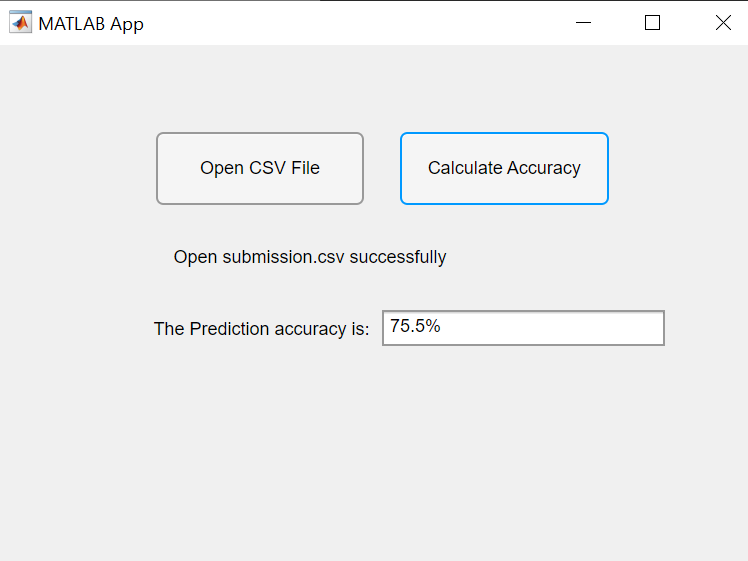

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

One of the central requirements of this project was to evaluate the performance of the developed deep learning model against a known baseline presented in the research paper titled *"Regressive Vision Transformer for Dog Cardiomegaly Evaluation in Radiography."* This paper introduced a novel model known as RVT and tested its performance—alongside other established architectures—on the DogHeart dataset. Among these, the VGG16 model served as a standard reference point for comparison.

The DogHeart dataset used in the RVT paper is identical to the one employed in this project. It comprises X-ray images of canine hearts, categorized into three classes: *Small*, *Normal*, and *Large*, based on measurements derived from the vertebral heart scale. The goal for each model was to classify these categories accurately, using both training and unseen test data for evaluation.

According to the RVT paper, the VGG16 model achieved:
- A **validation accuracy of 78.5%**
- A **test accuracy of 75.0%**

This project required the final model to exceed the VGG16 test accuracy of 75.0%. After training and evaluation, the model developed in this work—based on the EfficientNet-B0 architecture—achieved:
- A **validation accuracy of 74.5%**
- A **test accuracy of 75.5%**, as verified using the official evaluation tool

While the validation accuracy was slightly lower than that of the VGG16 benchmark, the test accuracy exceeded the required threshold. Since the project defined success based on test performance, the model meets the core criterion by delivering a higher accuracy on unseen data.

This comparison not only confirms the model’s effectiveness but also highlights its efficiency. Although more complex models like RVT reported higher accuracy in the paper, the goal of this project was not to surpass the RVT model itself, but to build a reliable and efficient model capable of outperforming VGG16. That objective has been achieved.

In conclusion, the comparison with the RVT paper demonstrates that the model developed in this project satisfies the performance requirement. It achieves a higher test accuracy than the VGG16 baseline and confirms that the chosen approach is suitable for solving the problem of canine heart size classification using radiographic data.


# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

### Report Link
[Deep Learning on Canine Thoracic X-Rays: Building a Classification Project with EfficientNet-B0](https://www.researchgate.net/publication/390179025_Deep_Learning_on_Canine_Thoracic_X-Rays_Building_a_Classification_Project_with_EfficientNet-B0)
